----------------


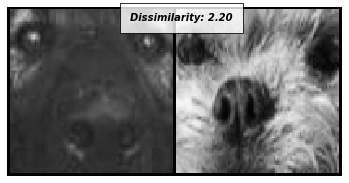

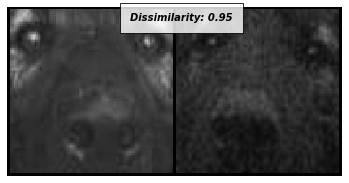

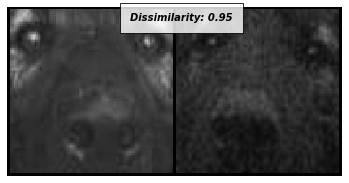

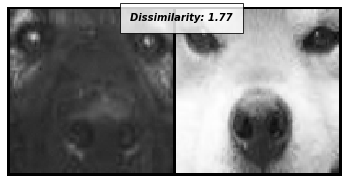

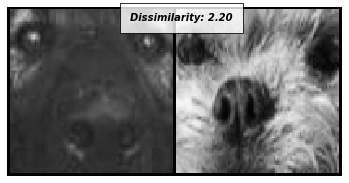

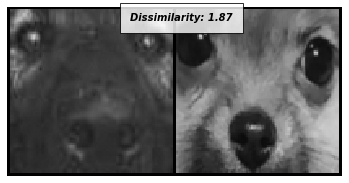

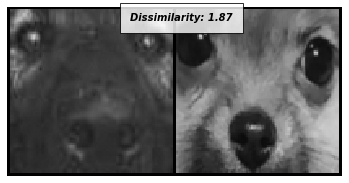

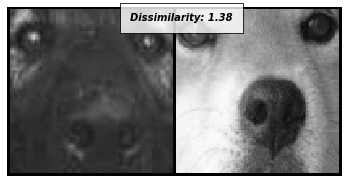

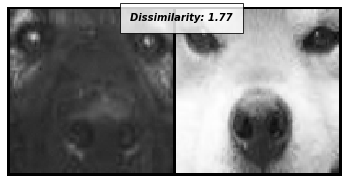

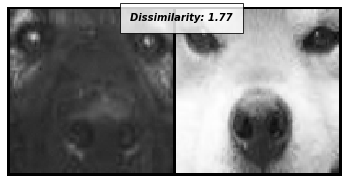

done!


In [2]:
import matplotlib.pyplot as plt
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
from torch.utils.data import DataLoader,Dataset
import torch.utils.data as Data
import PIL.ImageOps    
import torch.nn as nn
# from torch import optim
import torch.nn.functional as F
#plt.switch_backend('agg')

def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()


class Config():
    training_dir = "./data/faces/training/"
    testing_dir = "./data/faces/testing/"
    train_batch_size = 64
    train_number_epochs = 200

class SiameseNetworkDataset(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            while True:
                #keep looping till a different class image is found
                
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] !=img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size(0), -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

class ContrastiveLoss(torch.nn.Module):

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

if __name__ == '__main__':        

    net=SiameseNetwork()
    net.load_state_dict(torch.load('./net_params.pkl'))
    folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)
    siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                            transform=transforms.Compose([transforms.Resize((100,100)),
                                                                          transforms.ToTensor()]),
                                            should_invert=False)

    test_dataloader = DataLoader(siamese_dataset,num_workers=0,batch_size=1,shuffle=True)
    dataiter = iter(test_dataloader)
    #print(len(dataiter))#30张照片
    x0,tes,tes1 = next(dataiter)
    #print(x0)
    #print(tes)
    #print(tes1)
    
    print("----------------")
    #print(len(x0))
    #print(len(tes))
    #print(len(tes1))
    
    for i in range(10):
        _,x1,label2 = next(dataiter)
        concatenated = torch.cat((x0,x1),0)
    
        output1,output2 = net(Variable(x0),Variable(x1))
        euclidean_distance = F.pairwise_distance(output1, output2)
        imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))
    
    print("done!")